In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import os
from PIL import Image

In [14]:
df = pd.read_csv('/home/student/Desktop/New Folder 1/220962049_aiml/daily_csv.csv')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
df = df.dropna()

y = df['Price'].values
x = np.arange(1, len(y), 1)

print(len(y))

# Normalize the input range between 0 and 1
minm = y.min()
maxm = y.max()
print(minm, maxm)

y = (y - minm) / (maxm - minm)

Sequence_Length = 10
X = []
Y = []

for i in range(0, 5900):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
        X.append(list1)
        Y.append(y[j + 1])
        
#Convert from list to array
X = np.array(X)
Y = np.array(Y)

#Split the data as the train and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y,
test_size=0.10, random_state=42, shuffle=False, stratify=None)


5952
1.05 18.48


In [16]:
class NGT(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx].to(device), self.y[idx].to(device)

    def __len__(self):
        return self.len

dataset = NGT(x_train,y_train)

from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, shuffle=True, batch_size=256)

In [17]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

In [18]:
model = LSTMModel().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

for i in range(1, epochs+1):
    for j, data in enumerate(train_loader):
        y_pred = model(data[:][0].view(-1, Sequence_Length, 1)).reshape(-1)
        loss = criterion(y_pred, data[:][1])
        loss.backward()
        optimizer.step()
    if i % 5 == 0:
        print(i, "th iteration : ", loss)

5 th iteration :  tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)
10 th iteration :  tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
15 th iteration :  tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>)
20 th iteration :  tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)
25 th iteration :  tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
30 th iteration :  tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
35 th iteration :  tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
40 th iteration :  tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
45 th iteration :  tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)
50 th iteration :  tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


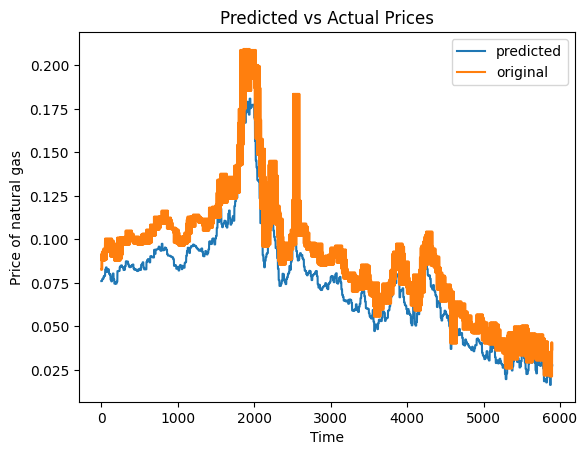

In [19]:
test_set = NGT(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,10,1)).view(-1)

plt.title("Predicted vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price of natural gas")
plt.plot(test_pred.detach().cpu().numpy(), label='predicted')
plt.plot(test_set[:][1].view(-1).cpu(), label='original')
plt.legend()
plt.show()

In [20]:
from glob import glob
import random
import string

names_dir_path = "/home/student/Desktop/New Folder 1/220962049_aiml/names/names"

class namesDataset(Dataset):
    def __init__(self, dir, train_split=0.9, max_length=None):
        super().__init__()
        
        self.train = True
        self.data = []
        
        self.labelToLang = {}
        
        # Mapping of characters to integers
        all_characters = string.ascii_lowercase
        self.n_characters = len(all_characters)
        self.char_to_index = {ch: i for i, ch in enumerate(all_characters)}
        
        file_names = glob(os.path.join(dir, "*.txt"))
            
        
        for lang_idx, file_name in enumerate(file_names):
            lang = file_name.split("/")[-1][:-4]
            self.labelToLang[lang_idx] = lang
            
            f = open(file_name, "r")
            self.data += [([self.char_to_index.get(ch, 0) for ch in name[:-1].lower()], lang_idx) for name in f.readlines()]
        
        self.max_length = max_length
        
        if self.max_length is None:
            self.max_length = max([len(data_point[0]) for data_point in self.data])
        
        random.shuffle(self.data)
        # print(self.data)
        
        self.train_data, self.test_data = self.data[:int(len(self.data) * train_split)], self.data[int(len(self.data) * train_split):]
        print(len(self.train_data), len(self.test_data))
        # print(self.test_data)
    
    def __len__(self):
        return len(self.train_data) if self.train else len(self.test_data)
    
    def __getitem__(self, idx):
        name, label = self.train_data[idx] if self.train else self.test_data[idx]
        
        # Pad name to have fixed length
        name = name[:self.max_length] + [0] * (self.max_length - len(name))
        
        return torch.Tensor(name).to(device), torch.tensor(label).to(device)

In [21]:
dataset = namesDataset(names_dir_path)

train_loader = DataLoader(dataset, shuffle=False, batch_size=32)
test_loader = DataLoader(dataset, shuffle=True, batch_size=16)

18066 2008


In [22]:
n_characters = dataset.n_characters
n_languages = len(dataset.labelToLang)

class LanguageModel(nn.Module):
    def __init__(self, n_characters=n_characters, n_languages=n_languages, hidden_size=5):
        super(LanguageModel, self).__init__()
        # self.embedding = nn.Embedding(n_characters, hidden_size)
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=5, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_languages)

    def forward(self, x):
        # x = self.embedding(x)  # [batch_size, seq_len, hidden_size]
        out, _ = self.lstm(x)  # Get the RNN output
        # print(out.size(), out)
        out = out[:, -1, :]  # Take the output of the last time step
        # print(out.size(), out)
        out = self.fc(out)  # Final linear layer for classification
        return out


In [23]:
learning_rate = 1e-3 * 5

model = LanguageModel(n_characters=n_characters, n_languages=n_languages).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
dataset.train = True
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for names, labels in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        names = names.unsqueeze(2)
        # labels = labels.unsqueeze(0)
        
        # Forward pass
        outputs = model(names)
        
        # print(labels.size(), outputs.size())
        # outputs = nn.functional.softmax(outputs, dim=1)
        
        # Compute loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # print(predicted, labels)
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/200], Loss: 1.9158, Accuracy: 44.11%
Epoch [2/200], Loss: 1.7577, Accuracy: 47.76%
Epoch [3/200], Loss: 1.6801, Accuracy: 49.33%
Epoch [4/200], Loss: 1.6658, Accuracy: 49.20%
Epoch [5/200], Loss: 1.6532, Accuracy: 49.25%
Epoch [6/200], Loss: 1.6319, Accuracy: 49.96%
Epoch [7/200], Loss: 1.6136, Accuracy: 50.41%
Epoch [8/200], Loss: 1.5953, Accuracy: 51.34%
Epoch [9/200], Loss: 1.5837, Accuracy: 52.04%
Epoch [10/200], Loss: 1.5783, Accuracy: 52.04%
Epoch [11/200], Loss: 1.5771, Accuracy: 52.37%
Epoch [12/200], Loss: 1.5654, Accuracy: 52.55%
Epoch [13/200], Loss: 1.5669, Accuracy: 52.93%
Epoch [14/200], Loss: 1.5928, Accuracy: 52.65%
Epoch [15/200], Loss: 1.6043, Accuracy: 52.03%
Epoch [16/200], Loss: 1.5555, Accuracy: 53.52%
Epoch [17/200], Loss: 1.5450, Accuracy: 53.95%
Epoch [18/200], Loss: 1.5346, Accuracy: 54.85%
Epoch [19/200], Loss: 1.5838, Accuracy: 53.32%
Epoch [20/200], Loss: 1.5647, Accuracy: 53.20%
Epoch [21/200], Loss: 1.5258, Accuracy: 54.38%
Epoch [22/200], Loss: 

In [25]:
dataset.train = False

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for names, labels in test_loader:
        names = names.unsqueeze(2)
        outputs = model(names)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 66.98%


In [26]:
with torch.no_grad():
    for i in range(50):
        name, label = dataset[i]
        name, label = torch.unsqueeze(name, 0), torch.unsqueeze(label, 0)
        name = name.unsqueeze(2)
        #print(name, label)
        outputs = model(name)
        _, predicted = torch.max(outputs, 1)
        # print(predicted)

        print("Actual:", dataset.labelToLang[label.detach().cpu().item()])
        print("Predicted:", dataset.labelToLang[predicted.detach().cpu().item()])
        print()

Actual: Polish
Predicted: English

Actual: Greek
Predicted: Arabic

Actual: English
Predicted: English

Actual: English
Predicted: Russian

Actual: English
Predicted: English

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: English

Actual: Russian
Predicted: Russian

Actual: Czech
Predicted: Russian

Actual: French
Predicted: English

Actual: Russian
Predicted: Russian

Actual: English
Predicted: English

Actual: Korean
Predicted: Chinese

Actual: English
Predicted: English

Actual: Scottish
Predicted: English

Actual: Russian
Predicted: Russian

Actual: Arabic
Predicted: English

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Irish
Predicted: English

Actual: Scottish
Predicted: English

Actual: Russian
Predicted: Russian

Actual: Arabic
Predicted: Arabic

Actual: Japanese
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Korean
Predicted: English

Act

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import string

In [28]:
text = """In one rearrangement proof, two squares are used whose sides have a measure of a + b and which contain four right triangles whose sides are a, b and c, with the hypotenuse being c. In the square on the right side, the triangles are placed such that the corners of the square correspond to the corners of the right angle in the triangles, forming a square in the center whose sides are length c. Each outer square has an area of ( a + b ) 2  well as 2 a b + c 2, with 2 a b representing the total area of the four triangles. Within the big square on the left side, the four triangles are moved to form two similar rectangles with sides of length a and b. These rectangles in their new position have now delineated two new squares, one having side length a is formed in the bottom-left corner, and another square of side length b formed in the top-right corner. In this new position, this left side now has a square of area ( a + b ) 2 as well as 2 a b + a 2 + b 2. Since both squares have the area of ( a + b ) 2 {\displaystyle (a+b)^{2}} it follows that the other measure of the square area also equal each other such that 2 a b + c 2 {\displaystyle 2ab+c^{2}} = 2 a b + a 2 + b 2 {\displaystyle 2ab+a^{2}+b^{2}}. With the area of the four triangles removed from both side of the equation what remains is a 2 + b 2 = c 2 . {\displaystyle a^{2}+b^{2}=c^{2}.} [2]

In another proof rectangles in the second box can also be placed such that both have one corner that correspond to consecutive corners of the square. In this way they also form two boxes, this time in consecutive corners, with areas a 2 {\displaystyle a^{2}} and b 2 {\displaystyle b^{2}}which will again lead to a second square of with the area 2 a b + a 2 + b 2 {\displaystyle 2ab+a^{2}+b^{2}}.

English mathematician Sir Thomas Heath gives this proof in his commentary on Proposition I.47 in Euclid's Elements, and mentions the proposals of German mathematicians Carl Anton Bretschneider and Hermann Hankel that Pythagoras may have known this proof. Heath himself favors a different proposal for a Pythagorean proof, but acknowledges from the outset of his discussion "that the Greek literature which we possess belonging to the first five centuries after Pythagoras contains no statement specifying this or any other particular great geometric discovery to him."[3] Recent scholarship has cast increasing doubt on any sort of role for Pythagoras as a creator of mathematics, although debate about this continues."""

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_6030/3836106867.py:1: SyntaxWarning: invalid escape sequence '\d'
  text = """In one rearrangement proof, two squares are used whose sides have a measure of a + b and which contain four right triangles whose sides are a, b and c, with the hypotenuse being c. In the square on the right side, the triangles are placed such that the corners of the square correspond to the corners of the right angle in the triangles, forming a square in the center whose sides are length c. Each outer square has an area of ( a + b ) 2  well as 2 a b + c 2, with 2 a b representing the total area of the four triangles. Within the big square on the left side, the four triangles are moved to form two similar rectangles with sides of length a and b. These rectangles in their new position have now delineated two new squares, one having side length a is formed in the bottom-left corner, and another squ

In [29]:
chars = sorted(set(text))
vocab_size = len(chars)
char_to_index = {ch: i for i, ch in enumerate(chars)}
index_to_char = {i: ch for i, ch in enumerate(chars)}

# Convert the text into numerical indices
encoded_text = [char_to_index[ch] for ch in text]

# Define sequence length (how many characters to look back to predict the next)
sequence_length = 10

# Prepare input-output pairs for training (X, y)
X = []
y = []

for i in range(len(encoded_text) - sequence_length):
    X.append(encoded_text[i:i + sequence_length])
    y.append(encoded_text[i + sequence_length])

X = torch.tensor(X)
y = torch.tensor(y)

# Step 2: Define the RNN model
class NextCharacterRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NextCharacterRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # Pass input through RNN layer
        out, hn = self.rnn(x, h0)
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        
        return out

# Hyperparameters
input_size = vocab_size  # One-hot encoding of each character
hidden_size = 128  # Number of RNN hidden units
output_size = vocab_size  # Predict next character
learning_rate = 0.001
epochs = 10000

# Model initialization
model = NextCharacterRNN(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Step 3: Train the model
# Convert input sequences to one-hot encoding
X_onehot = torch.zeros(X.size(0), X.size(1), vocab_size)

for i in range(X.size(0)):
    for j in range(X.size(1)):
        X_onehot[i, j, X[i, j]] = 1

# Training loop
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_onehot)
    
    # Compute loss
    loss = criterion(outputs, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Step 4: Predict next character
def predict_next_char(model, input_text, char_to_index, index_to_char, sequence_length=10):
    model.eval()

    # Prepare the input sequence
    input_indices = [char_to_index[ch] for ch in input_text[-sequence_length:]]
    input_tensor = torch.zeros(1, sequence_length, vocab_size)

    for i in range(sequence_length):
        input_tensor[0, i, input_indices[i]] = 1

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_index = torch.argmax(output, dim=1).item()
    
    return index_to_char[predicted_index]

# Test the model with a sequence of characters
input_text = "Hello, this is a "
predicted_char = predict_next_char(model, input_text, char_to_index, index_to_char)
print(f'Input text: "{input_text}" -> Predicted next character: "{predicted_char}"')


Epoch [500/10000], Loss: 0.1846
Epoch [1000/10000], Loss: 0.0580
Epoch [1500/10000], Loss: 0.0462
Epoch [2000/10000], Loss: 0.0424
Epoch [2500/10000], Loss: 0.0405
Epoch [3000/10000], Loss: 0.0395
Epoch [3500/10000], Loss: 0.0388
Epoch [4000/10000], Loss: 0.0384
Epoch [4500/10000], Loss: 0.0397
Epoch [5000/10000], Loss: 0.0387
Epoch [5500/10000], Loss: 0.0382
Epoch [6000/10000], Loss: 0.0380
Epoch [6500/10000], Loss: 0.0378
Epoch [7000/10000], Loss: 0.0377
Epoch [7500/10000], Loss: 0.0377
Epoch [8000/10000], Loss: 0.0379
Epoch [8500/10000], Loss: 0.0376
Epoch [9000/10000], Loss: 0.0376
Epoch [9500/10000], Loss: 0.0374
Epoch [10000/10000], Loss: 0.0374
Input text: "Hello, this is a " -> Predicted next character: "e"


In [30]:
# Test the model with a sequence of characters
input_text = "other measure of "

for i in range(50):
    predicted_char = predict_next_char(model, input_text, char_to_index, index_to_char)
    print(f'Input text: "{input_text}" -> Predicted next character: "{predicted_char}"')
    input_text += predicted_char

Input text: "other measure of " -> Predicted next character: "a"
Input text: "other measure of a" -> Predicted next character: " "
Input text: "other measure of a " -> Predicted next character: "+"
Input text: "other measure of a +" -> Predicted next character: " "
Input text: "other measure of a + " -> Predicted next character: "b"
Input text: "other measure of a + b" -> Predicted next character: " "
Input text: "other measure of a + b " -> Predicted next character: "a"
Input text: "other measure of a + b a" -> Predicted next character: "n"
Input text: "other measure of a + b an" -> Predicted next character: "d"
Input text: "other measure of a + b and" -> Predicted next character: " "
Input text: "other measure of a + b and " -> Predicted next character: "w"
Input text: "other measure of a + b and w" -> Predicted next character: "h"
Input text: "other measure of a + b and wh" -> Predicted next character: "i"
Input text: "other measure of a + b and whi" -> Predicted next character: "c"

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()  # Corrected super call
        self.rnn = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:, -1, :]
        output = self.fc(torch.relu(output))
        return output

data = list(range(25))
x, y = [], []

for i in range(5, 25):
    x.append(data[i-5:i])
    y.append(data[i])

x, y = torch.Tensor(x), torch.Tensor(y)

x, y = x.unsqueeze(2).to(device), y.to(device)  # Add channel dim & move to device

model = LSTMModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i in range(x.size(0)):
        optimizer.zero_grad()
        
        x_data = x[i].unsqueeze(0)  # Add batch dim
        y_data = y[i].unsqueeze(0)
        
        outputs = model(x_data)
        loss = criterion(outputs, y_data)
        
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / x.size(0)  # Fix loss calculation
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/200], Loss: 229.8332
Epoch [2/200], Loss: 207.3425
Epoch [3/200], Loss: 187.7792
Epoch [4/200], Loss: 161.3871
Epoch [5/200], Loss: 139.8797
Epoch [6/200], Loss: 123.9630
Epoch [7/200], Loss: 110.7329
Epoch [8/200], Loss: 99.4736
Epoch [9/200], Loss: 89.7901
Epoch [10/200], Loss: 81.4237
Epoch [11/200], Loss: 74.1824
Epoch [12/200], Loss: 67.9051
Epoch [13/200], Loss: 62.2994
Epoch [14/200], Loss: 56.1175
Epoch [15/200], Loss: 52.4789
Epoch [16/200], Loss: 48.2047
Epoch [17/200], Loss: 43.3130
Epoch [18/200], Loss: 39.2585
Epoch [19/200], Loss: 36.1624
Epoch [20/200], Loss: 33.2499
Epoch [21/200], Loss: 31.8214
Epoch [22/200], Loss: 28.0892
Epoch [23/200], Loss: 26.3870
Epoch [24/200], Loss: 24.7491
Epoch [25/200], Loss: 24.0487
Epoch [26/200], Loss: 20.5353
Epoch [27/200], Loss: 19.0391
Epoch [28/200], Loss: 17.6175
Epoch [29/200], Loss: 16.5821
Epoch [30/200], Loss: 15.2909
Epoch [31/200], Loss: 14.9130
Epoch [32/200], Loss: 13.2505
Epoch [33/200], Loss: 12.9660
Epoch [34/20

In [38]:


x = torch.Tensor([1, 2, 3, 4, 5])
x = x.unsqueeze(0).unsqueeze(2).to(device)

with torch.no_grad():
    out = model(x)
    print(out)



tensor([[5.7834]], device='cuda:0')
